In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj


%matplotlib notebook
%load_ext autoreload
%autoreload 2


np.random.seed(42)

In [2]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
        

In [3]:
dtype = torch.float
#device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU


number_nei = 7


# N is batch size (number of datasets); D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out =  (number_nei+1)*4, 10, 2 #1550

l_o = D_in




learning_rate = 1e-3

iterations = 500

batch_size = 20

mode = "wrap"



In [4]:
FPS = 16

BG = "Datasets/UG/ug.png"

PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-045.txt"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH_1)

PATH = "Datasets/AO/"
PATH2 = "data/CSV/"
fname = "ao-240-400_combine"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH + fname + ".txt")
#ds = DataLoader(PATH2 + fname + ".csv")
ds = DataLoader(PATH + fname + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

f_x = ds.flip_x
train, val, test = ds.get_train_data(number_nei, augmentation=[f_x], shuffle=True, mode=mode)


N/A% (0 of 352) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

loaded 352 persons
Persons:  352
Frame maximum : 1128


100% (352 of 352) |######################| Elapsed Time: 0:03:19 Time:  0:03:19


loaded 352 trajectories
with augmentation 704 trajectories
extracted 299808 steps


In [5]:
t_input, t_truth = train
v_input, v_truth = val

In [6]:
t_i = torch.from_numpy(t_input).to(device)
t_t = torch.from_numpy(t_truth).to(device)

v_i = torch.from_numpy(v_input).to(device)
v_t = torch.from_numpy(v_truth).to(device)


In [7]:
#x_batches, x_seqs, x_seq_len, x_features = t_i.shape

# Define Model

In [8]:

#define network



model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    
    torch.nn.ReLU(),
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(50, 30),
    
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(30, D_out), 
)



hidden_size = 28#50
hidden_size2 = 20
hidden_size3 = 10#50
hidden_size4 = 10


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
         
        out = self.drop( self.fc3(out) )
        
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(D_in, hidden_size, hidden_size2, hidden_size3, hidden_size4,D_out).to(device)


#if device.type.startswith("cuda"):
#    model.cuda()

In [9]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:

d_len = t_i.shape[0]


pbar = progressbar.ProgressBar(max_value=iterations)

widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=iterations*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(iterations):
    
    # Train on Batches
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, batch_size)):
        y_pred = model(t_i_b)


        """if t==1000:
            lr = 1e-5
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        if t==4000:
            lr = 1e-6
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr"""

       
        loss = loss_fn(y_pred, t_t_b)

        model.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('t-loss: {:.4} | v-loss:{:.4}'.format(loss.item(), validation_loss[-1]))
        pbar.update(t*d_len+y*batch_size)
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    for v_i_b, v_t_b in batch(v_i, v_t, batch_size):
        y_pred = model(v_i_b)
        loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
    validation_loss.append( np.array(loss).mean() )
        

pbar.finish()

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])






t-loss: 92.11 | v-loss:237.5   0% |                            | ETA:   4:47:35

<IPython.core.display.Javascript object>


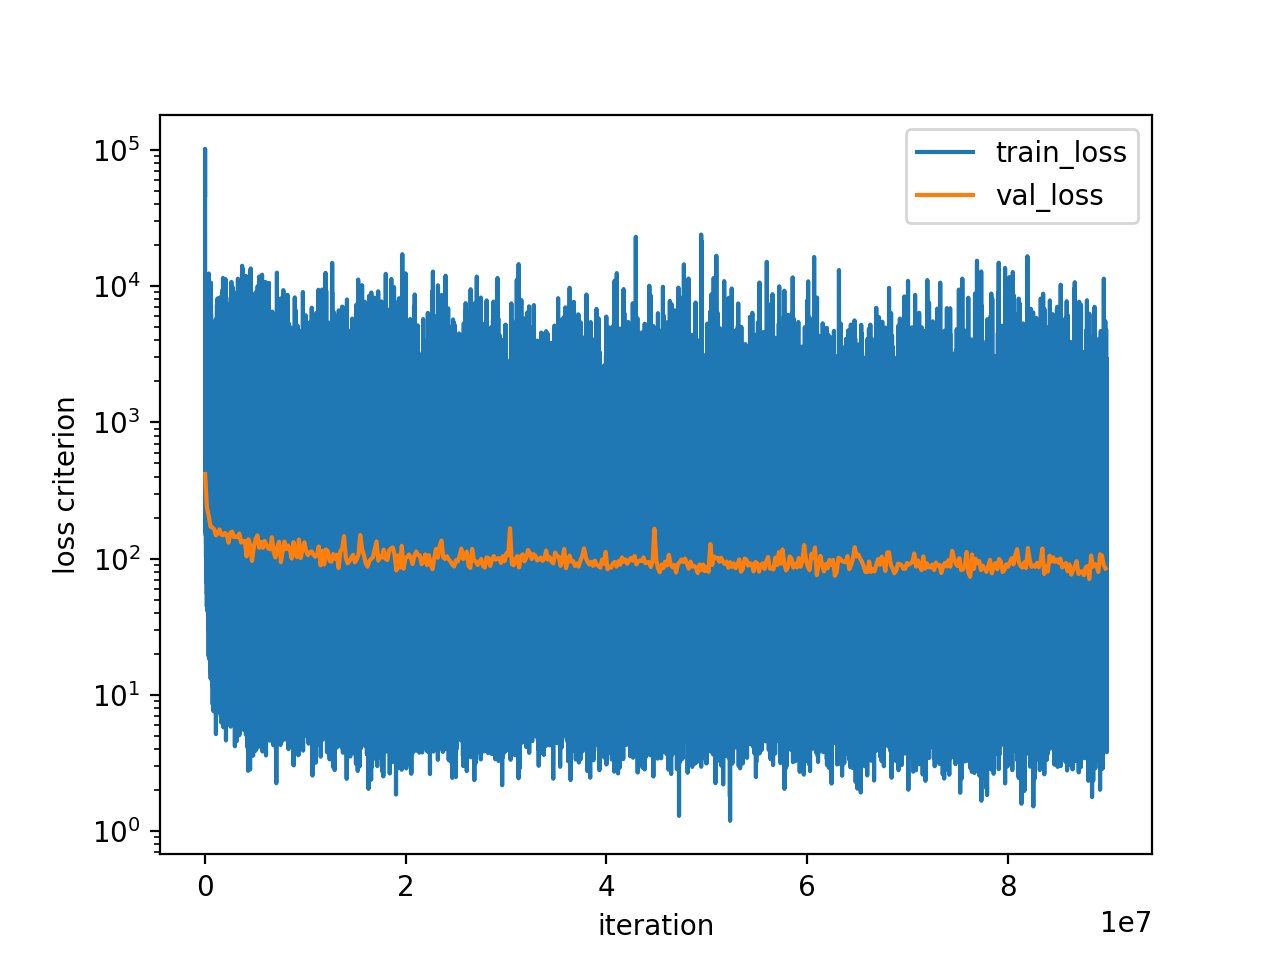

500
449500


In [24]:
plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*batch_size, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss))*d_len, val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [ ]:
torch.save(model.state_dict(), "data/model/model_domi_alex_model.dat")

352


<IPython.core.display.Javascript object>


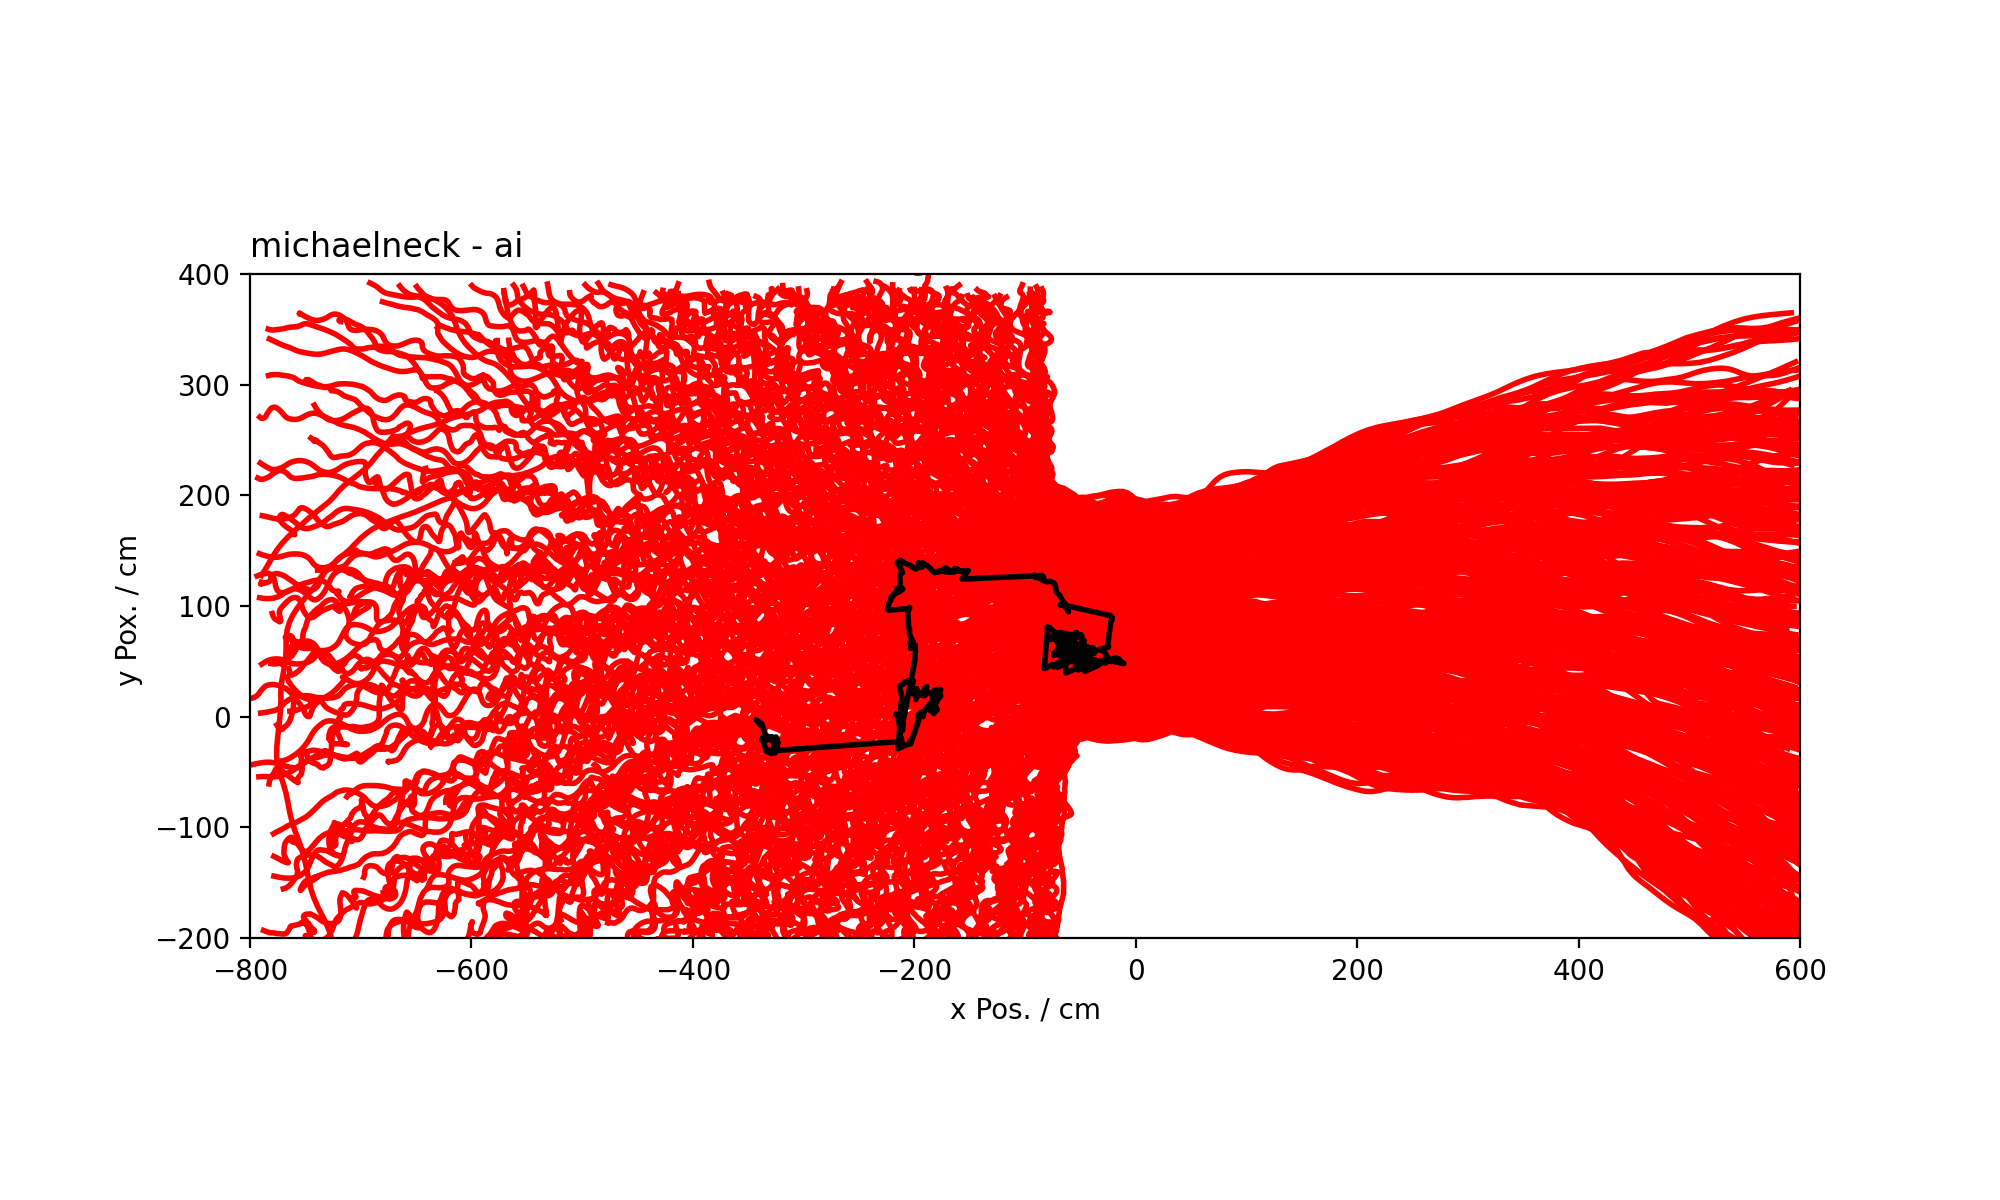

In [25]:
# make a copy from data
step_nr = 1
da = DataLoader(None)
da.copy(ds)

print(da.persons)


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
import pandas as pd

id = 40
frames, traj = da.person(id)
frame0 = frames[0]

#steps = da.data['f'].max() - da.data['f'].min()
steps = int(830 - frame0)

with torch.no_grad():
    for i in range(steps-step_nr):
        if step_nr == 1:
            inp = da.frame_nn(frame0+i, id, number_nei, mode="wrap", use_roi=False)[1]
        else:
            temp = []
            for j in range(step_nr):
                temp.append(da.frame_nn(frame0 + i + j, id, number_nei, mode="wrap", use_roi=False)[1])
            
            inp = np.vstack(temp)
        
        #if not nn_vel:
        #    inp = np.concatenate((inp[0,:], inp[1:,0:2].ravel()))
        
        inp = inp.ravel().astype(np.float32)
        x_sim = torch.from_numpy(inp).to(device)
        y_sim = model(x_sim)

        v_sim = (y_sim[:2]-x_sim[:2])/FPS
        pos = y_sim.cpu().detach().numpy()
        vel = v_sim.cpu().detach().numpy()
        
        entry = np.concatenate(([id], [frame0 + i + 1], np.flip(pos), [0], vel))
        
        if len(da.data[(da.data["p"]==id) & (da.data["f"]==frame0 + i + 1)]):
            da.data[(da.data['p']==id) & (da.data['f']==frame0 + i + 1)] = [entry]
        else:
            da.data = da.data.append(pd.DataFrame([entry], columns=list(da.data)), ignore_index=True)  

plotTraj(da, boundaries=[-800, 600, -200, 400], ai = [id], title="michaelneck - ai", save=False)

dataset
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-342.0740966796875 -3.1693973541259766 0.02855682373046875
  -0.007545456290245056]
 [-341.6232604980469 -3.655576705932617 0.028177261352539062
  -0.03038620948791504]
 [-341.1446228027344 -4.076450347900391 0.02991485595703125
  -0.02630460262298584]
 [-339.97174072265625 -5.972286224365234 0.07330513000488281
  -0.11848974227905273]]


<IPython.core.display.Javascript object>


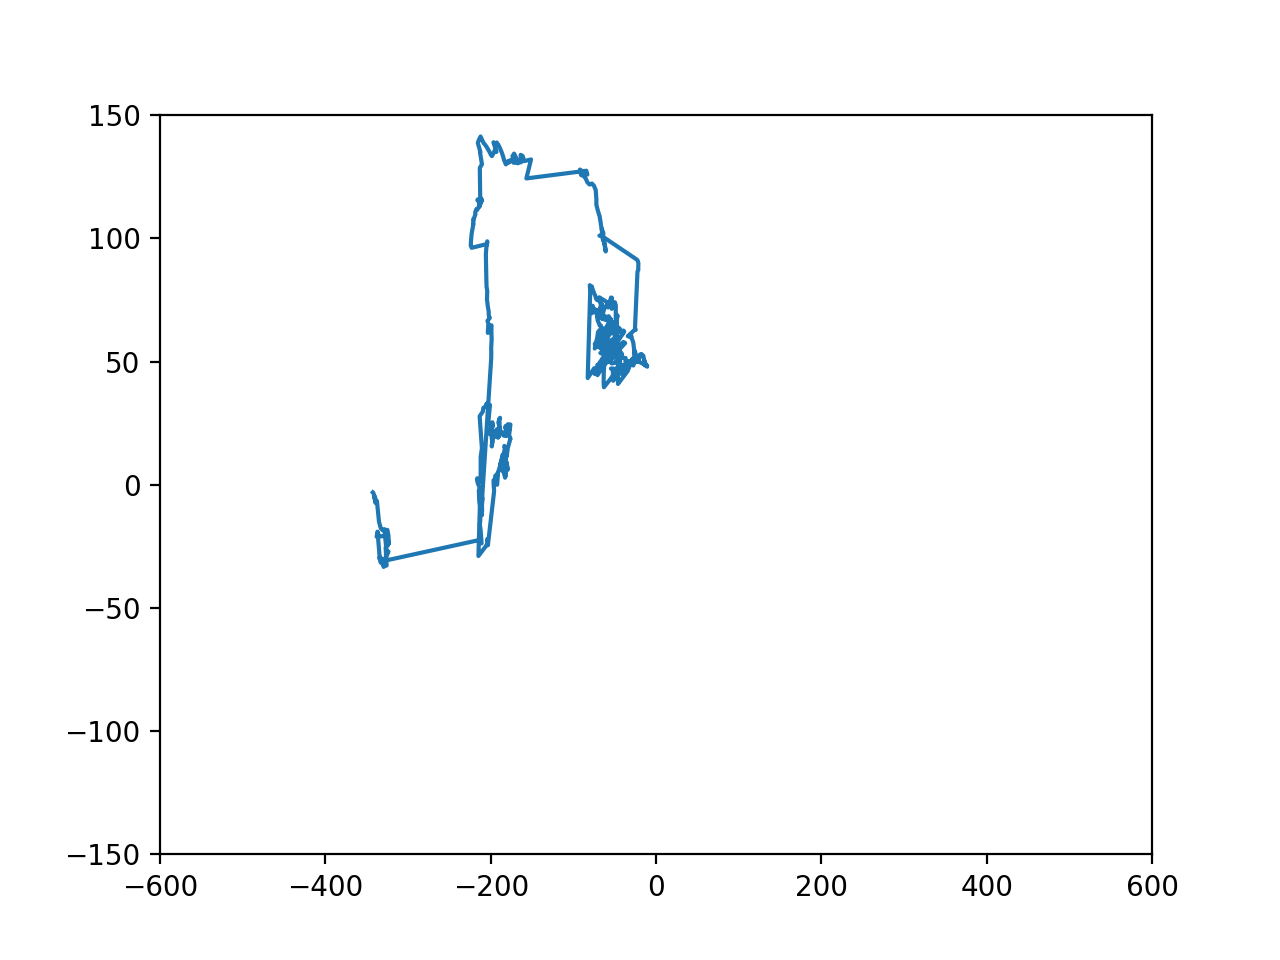

30.0


In [26]:
frames, traj = da.person( id)

print("dataset")
#print(frames[:])
print(traj[:5])

plt.figure()

offset = 0

#plt.plot(tr[:,1], tr[:,0]) 



plt.plot(traj[offset:,0], traj[offset:,1])

print(frames[offset])

plt.xlim([-600, 600])
plt.ylim([-150, 150])

plt.show()

In [34]:
class Agent():
    def __init__(self, model, pos_vel_0, id=100, frame_0=0, T=16, device="cpu"):
        
        
        self.id = id
        
        self.model = model
        self.device = device
        
        if self.device.type.startswith("cuda"):
            self.model.cuda()
        
        print(pos_vel_0)
        self.pos_vel_0 = pos_vel_0.copy()
        self.frame_c = frame_0
        
        self.T = T
        
        # position and velocity data
        self.frames = [frame_0]
        self.traj = [pos_vel_0]
                
    @property 
    def pos(self):
        return self.traj[-1][ :2]
    
    @property
    def vel(self):
        return self.traj[-1][ 2:]
        
    def step(self, neighbors):
        
        with torch.no_grad():
            x_sim = torch.from_numpy(neighbors).to(self.device)

            y_sim = model(x_sim.float())

        v_sim = (y_sim[:2]-x_sim[:2])*self.T
        
        self.traj.append( np.concatenate( (y_sim.cpu().detach().numpy(), v_sim.cpu().detach().numpy()) ) )
        self.frame_c +=1
        self.frames.append(self.frame_c)
        
        return self.traj[-1]
        

In [35]:
class Engine():
    def __init__(self, ds, agents=[], nn=10, stop_agent=False, mode="wraps", exportpath="sim.csv"):
        
        self.ds = DataLoader(exportpath)
        self.ds.copy(ds)
        
        self.agents = agents
        
        self.nn = nn
        self.mode = mode
        self.stop_agent = stop_agent
        
        self.cur_f = 0
        
    def step(self, ):
        
        for a in self.agents:
            if a.pos[0]>500 and self.stop_agent:
                continue
            
            _, pos_vel = self.ds.frame_nn(self.cur_f, a.id, nn=self.nn, use_roi=False, mode=self.mode)
            
            n_pos_vel = a.step(pos_vel.copy().ravel()).copy()
            #print("===STEP===")
            #print(n_pos_vel)
            #print(a.traj[-1])
            
            n_pos_vel [[0, 1]] = n_pos_vel [[1, 0]]
           
            
            # TODO write to ds
            entry = np.concatenate( ([a.id], [self.cur_f+1], n_pos_vel[:2], [0], n_pos_vel[2:] ) )
            
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)] = [entry]
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)    
                
            #print(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)])
            
            #_, traj = sim.ds.person(test_person+100)
            #print(traj[:5])

        self.cur_f += 1
        
    
    def run(self, start_f, stop_f, ):
        self.cur_f = start_f
        print("sim from : {} to {}".format(start_f, stop_f))
        widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
        pbar = progressbar.ProgressBar(widgets=widgets, maxval=stop_f)
        pbar.start()
        
        for  a in self.agents:

            pos = a.pos_vel_0[:2]
            
            entry = np.concatenate( ([a.id],  [a.frame_c], np.flip(pos) , [0],  a.pos_vel_0[2:]) )
            
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)] = [entry]
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)
        
        
        while self.cur_f < stop_f:
            self.step()
            #print("===RUN===")
            #print(self.agents[-1].traj[-1])
            #print(self.ds.data[(self.ds.data["p"]==self.agents[-1].id) & (self.ds.data["f"]==self.cur_f)])
            widgets[0] = FormatLabel('frame: {:4}'.format(self.cur_f))
            pbar.update(self.cur_f)
        
        pbar.finish()


    
    def save(self, ):
        pass
        

In [36]:

test_person = 40

da = DataLoader(None)

da.copy(ds)

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(pos_vel_o.shape)

agent = Agent(model, pos_vel_0=pos_vel_o[0], frame_0=frames_o[0], device=device, id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent], nn=number_nei, mode=mode, )

sim.run(frames_o[0], 830)#frames_o[-1], )



frame:   43   5% |##                                           | ETA:   0:00:02

(249, 4)
[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
1040
[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
sim from : 30 to 830


frame:  830 100% |#############################################| Time:  0:00:07


agent
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-342.0740966796875 -3.1693973541259766 7.310453125000095
  -1.9316376660156251]
 [-338.6265563964844 -11.764057159423828 55.16064453125
  -137.51455688476562]
 [-333.450439453125 -40.38077163696289 82.81787109375 -457.867431640625]
 [-329.9986267089844 -68.13789367675781 55.22900390625
  -444.11395263671875]]
[-3.38460317e+29 -9.64777961e+29]
dataset
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-342.0740966796875 -3.1693973541259766 7.310453125000095
  -1.9316376660156251]
 [-338.6265563964844 -11.764057159423828 55.16064453125
  -137.51455688476562]
 [-333.450439453125 -40.38077163696289 82.81787109375 -457.867431640625]
 [-329.9986267089844 -68.13789367675781 55.22900390625
  -444.11395263671875]]


<IPython.core.display.Javascript object>


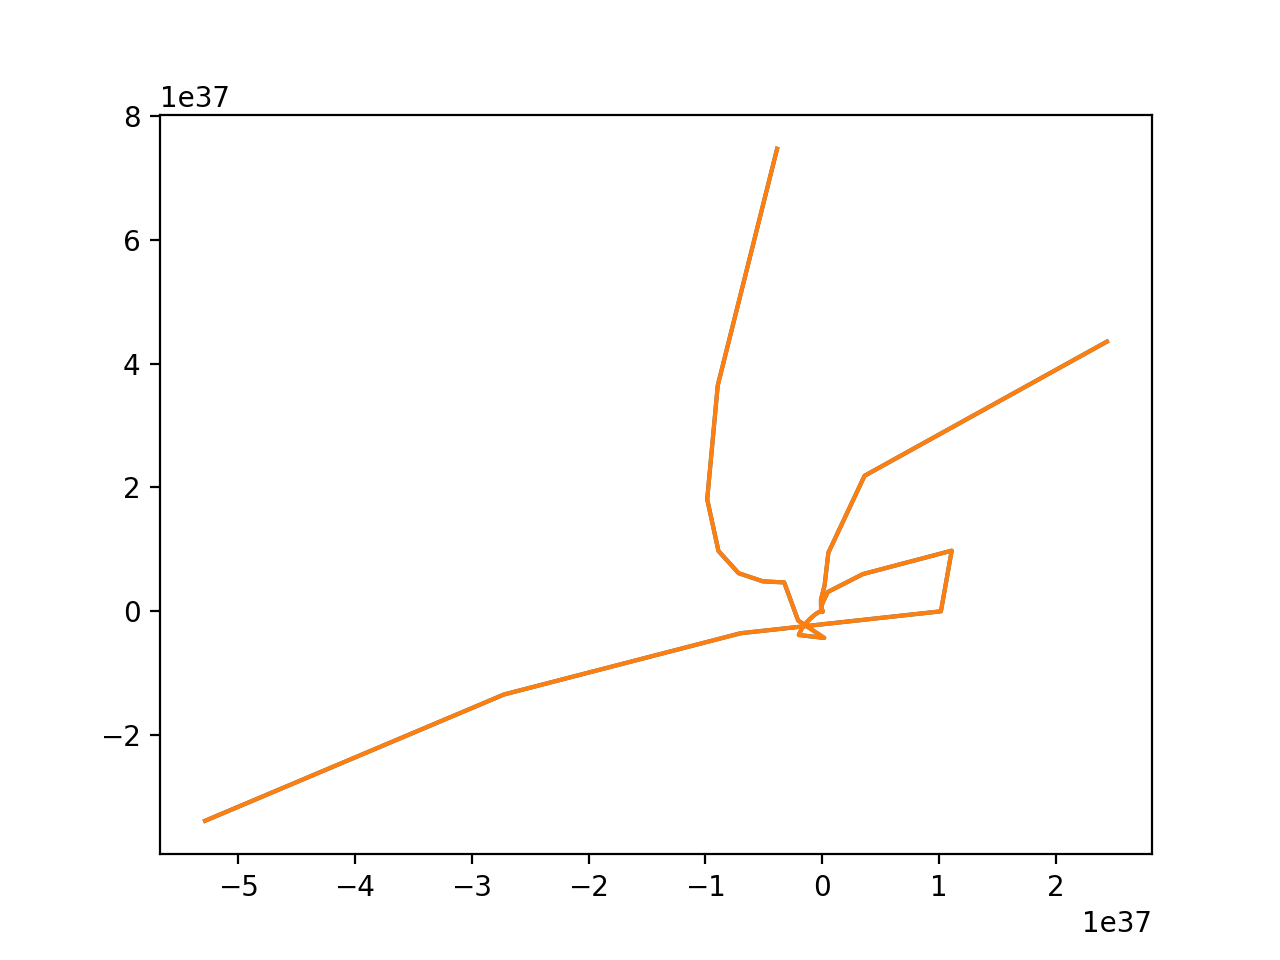

30.0


'\n[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]\n [-332.4825439453125 -3.1519365310668945 0.6280288696289062\n  -0.006454154849052429]\n [-322.0271301269531 -2.130854606628418 0.6534633636474609\n  0.06381762027740479]\n [-312.77081298828125 -3.785721778869629 0.5785198211669922\n  -0.10342919826507568]\n [-302.70819091796875 -2.7985124588012695 0.6289138793945312\n  0.06170058250427246]]\n\n'

In [37]:
ai = sim.agents[0]
tr = np.vstack( ai.traj )

print("agent")
print(tr[:5])

print(ai.pos)
frames, traj = sim.ds.person(test_person+1000)

print("dataset")
#print(frames[:])
print(traj[:5])

plt.figure()

offset = 0
end = -1
plt.plot(tr[:,0], tr[:,1]) 



plt.plot(traj[offset: end,0], traj[offset:end,1])

print(frames[offset])

#plt.xlim([-600, 600])
#plt.ylim([-150, 150])

plt.show()

"""
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-332.4825439453125 -3.1519365310668945 0.6280288696289062
  -0.006454154849052429]
 [-322.0271301269531 -2.130854606628418 0.6534633636474609
  0.06381762027740479]
 [-312.77081298828125 -3.785721778869629 0.5785198211669922
  -0.10342919826507568]
 [-302.70819091796875 -2.7985124588012695 0.6289138793945312
  0.06170058250427246]]

"""

In [38]:
dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )



<IPython.core.display.Javascript object>


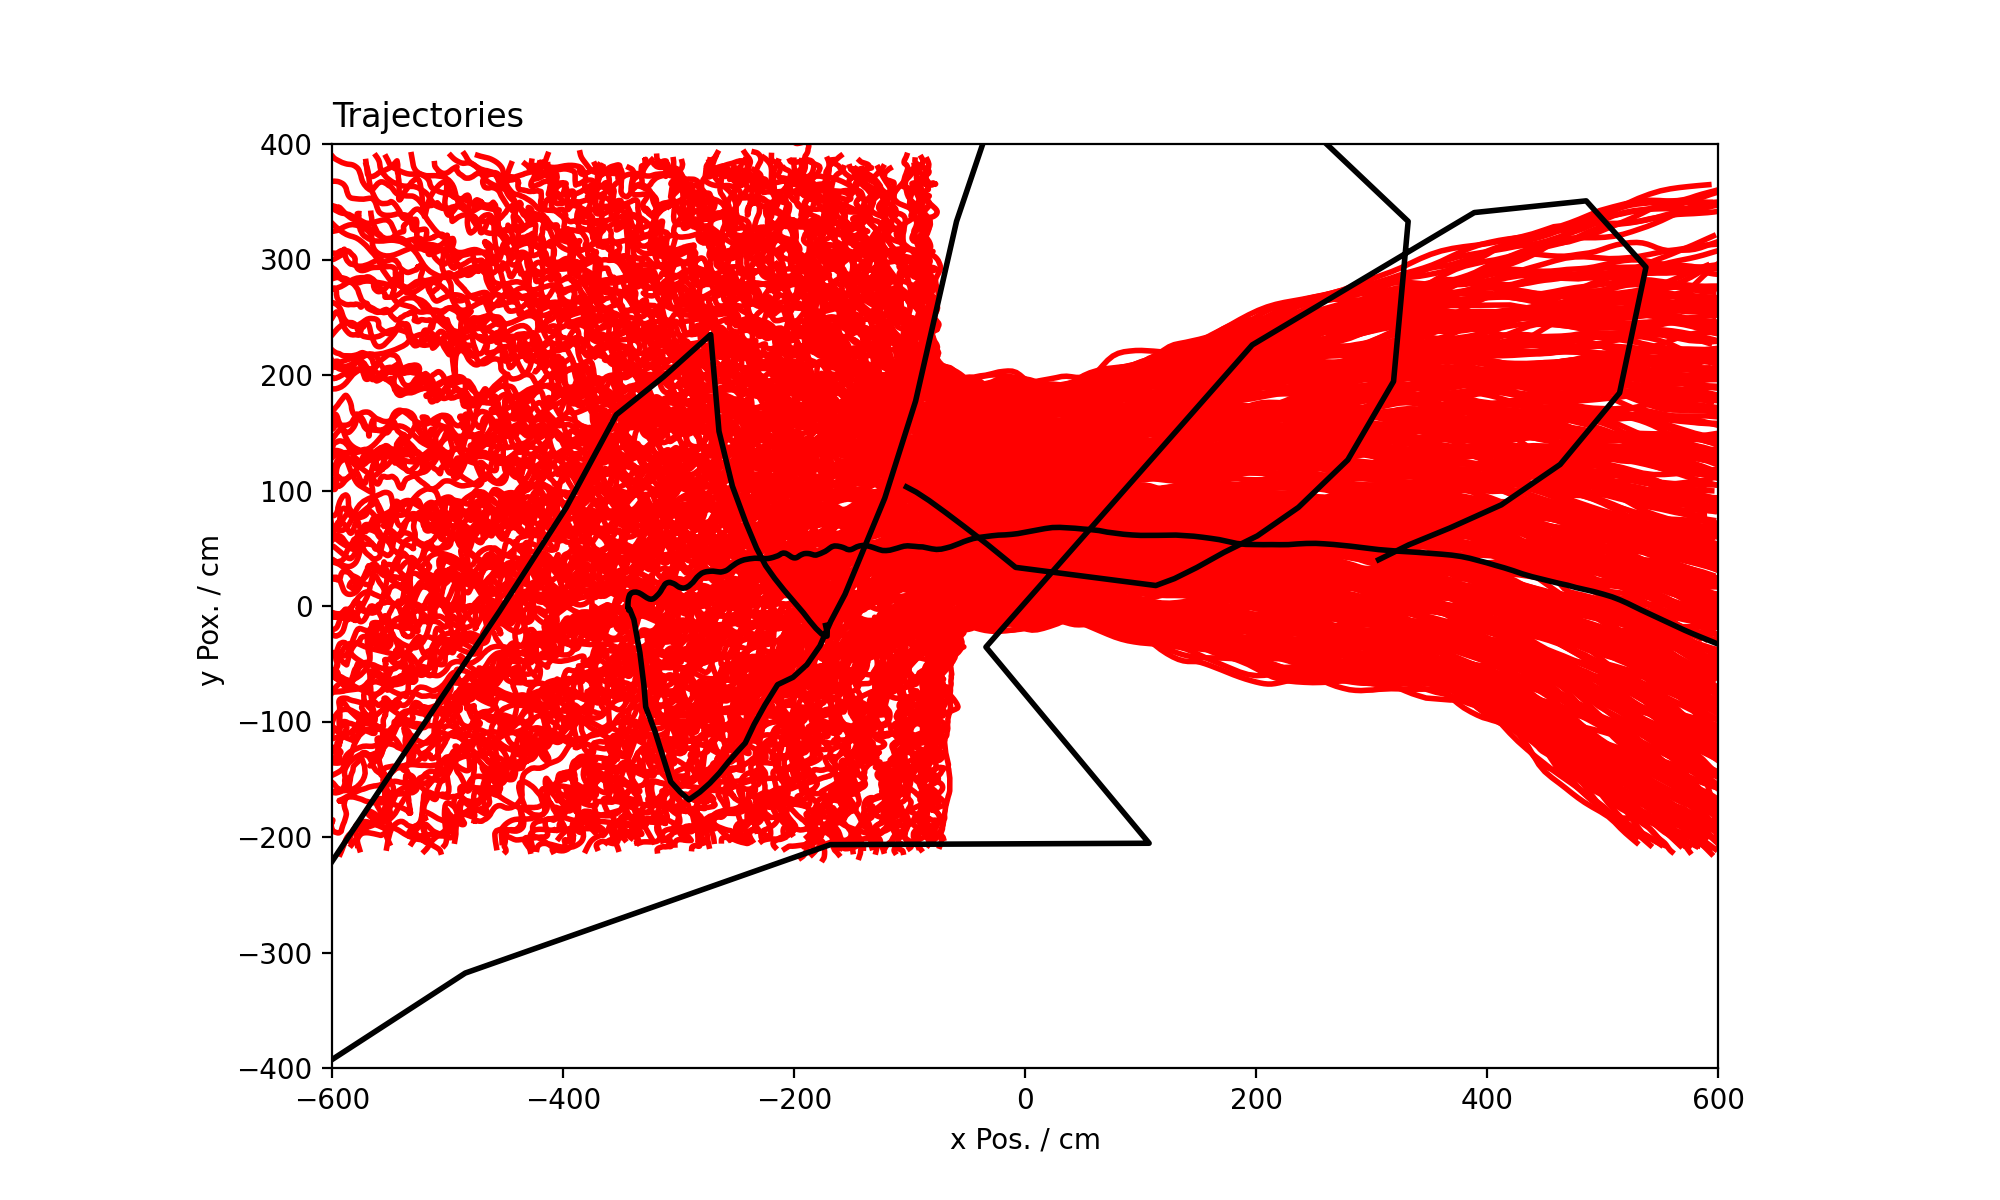

In [39]:

plotTraj(dp,  boundaries=[-600, 600, -400, 400],
         people=None,
         ai=[test_person, 1000+test_person],
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


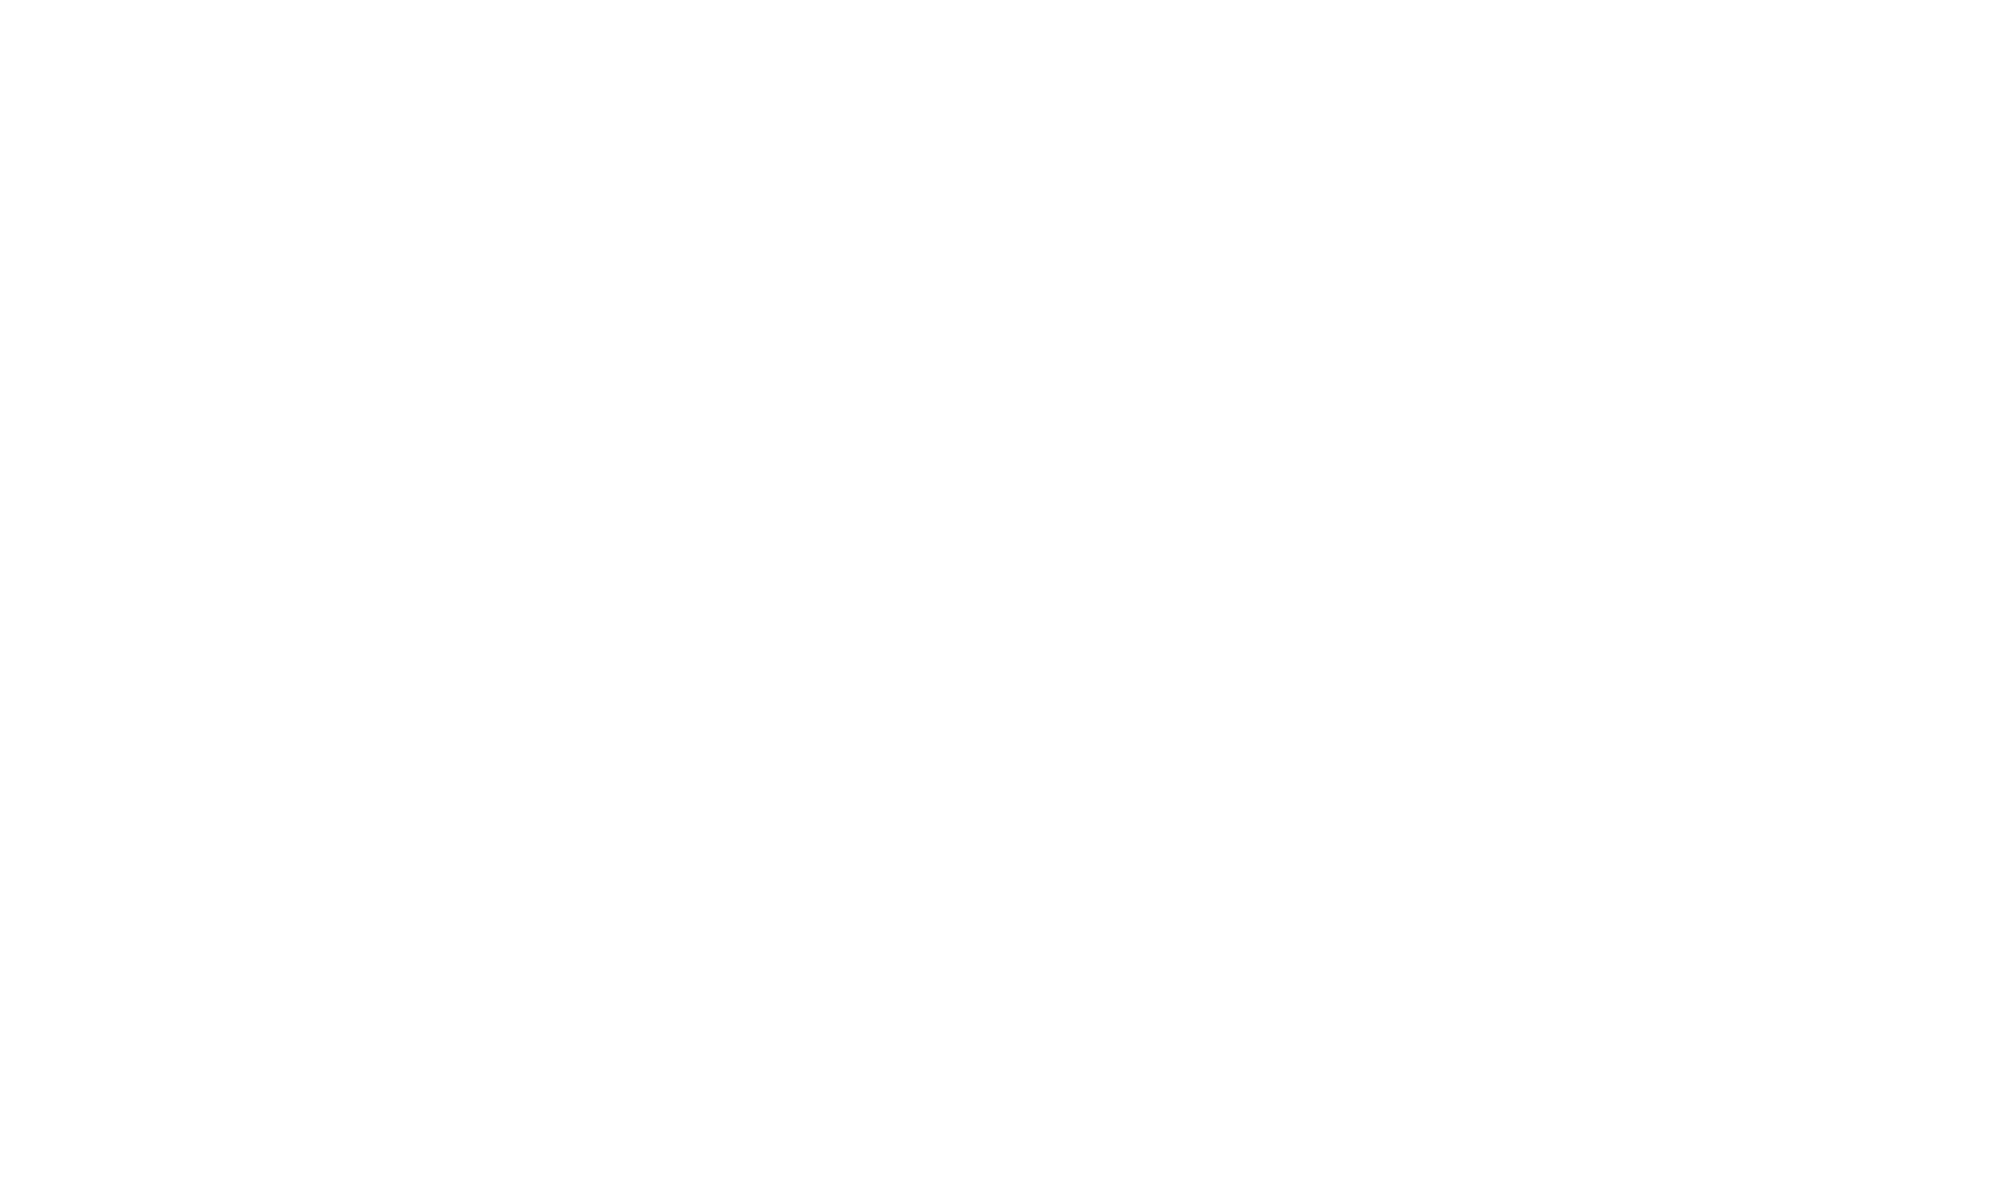

In [33]:
ani = animateLoc(dp, frame_start=frames[offset], frame_stop=frames[end],ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="ululululu", save=False)
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames[0], frame_stop=frames[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [ ]:
id_s, trajs = da.get_trajectories(number_nei)

In [ ]:



id = 15
mask = np.zeros_like(id_s, dtype=np.bool)




j, traj = id_s[id], trajs[id]
   
print(j)

frames, pos_vel =da.person(j) 

frames, _ = da.grab_roi(frames, pos_vel )



for i in range(len(traj)-1):
    print(traj[i], traj[i].shape)
    x_sim = torch.from_numpy(traj[i]).to(device)
    
    
    
    y_sim = model(x_sim)
    
    agent.step(traj[i])
    
    v_sim = (y_sim[:2]-x_sim[:2])/FPS
    traj[i+1, :2] = y_sim.cpu().detach().numpy()
    traj[i+1, 2:4] = v_sim.cpu().detach().numpy()



da.append_person(100+j,frames,  traj[:,:2])

In [ ]:
animatePreview(da, boundaries=[-600, 600, -250, 150], step=10)

In [ ]:
plotTraj(da,  boundaries=[-600, 600, -250, 150],
         people=None,
         ai=[20, 120],
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

In [ ]:
torch.save(model.state_dict(), "model.dat")

In [ ]:
ani = animateTraj(da, frame_start=220, frame_stop=370, boundaries=[-600, 600, -250, 150], step=5, fps=16, title="Trajectory Animation")
ani

In [ ]:
test = []

In [ ]:
test[-1]

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.ModuleDict({
            'lstm': torch.nn.LSTM(
                input_size=D_in,    # 45, see the data definition
                hidden_size=l_o,  # Can vary
            ),
            'linear1': torch.nn.Linear(
                in_features=l_o,
                out_features=D_out)
        })
        
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
      

        # Data is fed to the Linear layer
        out = self.model['linear1'](out)
       

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
       

        return y_pred


model = Model()